# Lab 5: Spam Detection

**Deadline**: Thursday, March 12, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Karthik Bhaskar 

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/11qbY9zYPxLS_MbkY955kjKuD0mh44-QY/view?usp=sharing

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import torchtext
import matplotlib.pyplot as plt

In [125]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/3rd year/2nd semester/aps360/Colab Notebooks/lab5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [133]:
spam = False
ham = False
for line in open('SMSSpamCollection'):
  if line.split()[0] == 'ham' and ham == False:
    ham = True
    print(line)
  elif line.split()[0] == 'spam' and spam == False:
    spam = True
    print(line)
  if ham == True and spam == True:
    break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [134]:
spam_count = 0
ham_count = 0
for line in open('SMSSpamCollection'):
  if line.split()[0] == 'ham':
    ham_count += 1
  elif line.split()[0] == 'spam':
    spam_count+= 1
print ('there are {} spam messages and {} non-spam messages in the dataset'.format(spam_count, ham_count))
'''
spam = 747
non-spam = 4827
'''

there are 747 spam messages and 4827 non-spam messages in the dataset


'\nspam = 747\nnon-spam = 4827\n'

### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [0]:
'''
Advantage
1. Using only characters allows for the neural network to ignore spelling mistakes
    within the dataset. Some peices of data may have spelling mistakes where
    if you use words, it will not be able to detect the definition
2. For a dataset you are analyzing, the dataset may use thousands of different words
    which would create very large word embeddings. With characters, there are 26 
    letters in the alphabet. With all punctuation marks, it is less than 100 characters
    therefore requires a smaller amount of embeddings for the input
Disadvantage
1. Slower computation as the neural network has to compute each character on its own
    and each characer has many more features (more possible characters next to it). 
    Looking for the third word would require 15 computations (5 letters on avg for 
    a word) whie using words would only require 3
2. Only remembers order of characters and not the context of complete words within
    a sentence which may result in random sentenses without much meaning
'''

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [135]:
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

print(dataset[0].sms)
print(dataset[0].label)
train, valid, test = dataset.split(split_ratio=[.6, .2, .2])
print(len(train), len(valid), len(test))

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
0
3343 1115 1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating non-spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [0]:
'''
With an imbalanced dataset, the resulting accuracy will not give much insight. 
For example, if 70% of the data has a label of 1, the accuracy will approach 
a high value quickly, roughly 70%. Although the accuracy will be great for the data 
with label 1, the accuracy for data with a label of 0 may have a significantly 
low accuracy showing that the AI is unable to determine the labels of 0 properly, 
even with a large accuracy
'''

In [136]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6
print(len(train))

6073


### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [137]:
text_field.build_vocab(train)
print(text_field.vocab.stoi)
'''
creates a dictionary that contains each word/token as a key and the index of the
vocab/token list as the value
'''
text_field.vocab.itos
print(text_field.vocab.itos)
print(len(text_field.vocab.stoi))
'''
a list of tokens with an index corresponding to the dictionary created above
'''

defaultdict(<function _default_unk_index at 0x7f95a2a150d0>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, 'T': 27, '8': 28, 'k': 29, 'E': 30, 'v': 31, '5': 32, 'C': 33, 'S': 34, 'O': 35, 'I': 36, 'N': 37, '7': 38, '4': 39, 'A': 40, 'x': 41, '6': 42, '3': 43, '!': 44, 'R': 45, 'P': 46, ',': 47, '9': 48, 'W': 49, 'U': 50, 'M': 51, 'L': 52, 'H': 53, 'B': 54, 'D': 55, 'G': 56, 'Y': 57, 'F': 58, "'": 59, '/': 60, '?': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, 'K': 69, 'j': 70, '*': 71, ')': 72, 'J': 73, '+': 74, ';': 75, '(': 76, 'Q': 77, 'q': 78, '"': 79, '>': 80, '#': 81, '@': 82, '=': 83, 'Z': 84, 'ü': 85, 'Ü': 86, '$': 87, '<': 88, '\x92': 89, '|': 90, '‘': 91, '_': 92, '\x93': 93, '“': 94, '…': 95, '%': 96, '[': 97, ']': 98, '–': 99, '\x94': 100, 'é': 101, '\t': 102, 

'\na list of tokens with an index corresponding to the dictionary created above\n'

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [0]:
'''
<unk> token is used a word is not found in the vocabulary list within torch text
<pad> token is used to represent padding within a text
'''

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [0]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [139]:
it = 1
pad_index = torch.tensor([text_field.vocab.stoi['<pad>']])
for batch in train_iter:
  sms_length_max = 0
  sms_length = 0
  pad_count = 0
  for i in range(len(batch.sms[0])):
    sms_length = 0
    for j in range(len(batch.sms[0][i])):
      sms_length_max = max(sms_length_max, sms_length)
      if (batch.sms[0][i][j]) == pad_index:
        pad_count += 1
        sms_length = 0
      else:
        sms_length += 1
  print('for sequence {}, the number of pads are {}, '.format(it, pad_count) + 
        'the max length of text in characters in this sequence is {}'.format(sms_length_max))
  it+=1
  if it > 10:
    break

for sequence 1, the number of pads are 35, the max length of text in characters in this sequence is 106
for sequence 2, the number of pads are 83, the max length of text in characters in this sequence is 165
for sequence 3, the number of pads are 57, the max length of text in characters in this sequence is 110
for sequence 4, the number of pads are 24, the max length of text in characters in this sequence is 34
for sequence 5, the number of pads are 9, the max length of text in characters in this sequence is 36
for sequence 6, the number of pads are 107, the max length of text in characters in this sequence is 19
for sequence 7, the number of pads are 26, the max length of text in characters in this sequence is 126
for sequence 8, the number of pads are 0, the max length of text in characters in this sequence is 159
for sequence 9, the number of pads are 0, the max length of text in characters in this sequence is 158
for sequence 10, the number of pads are 68, the max length of text in

## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [140]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [0]:
'''
include_max_or_avg
0 is no max no avg
1 is max no avg
2 is max and avg
'''
class Spammer(nn.Module):
    def __init__(self, input_size, hidden_size, include_max_or_avg = 0):
        super(Spammer, self).__init__()
        self.include_max_or_avg = include_max_or_avg
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.ident = torch.eye(input_size)
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        x, _ = self.rnn(self.ident[x], h0)
        if self.include_max_or_avg == 1:
          x = torch.max(x, dim=1)[0]
        if self.include_max_or_avg == 2:
          x = torch.cat([torch.max(x, dim=1)[0], torch.mean(x, dim=1)], dim=1)
        x = self.fc(x[:, -1, :])
        return x

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [0]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    for txts, labels in data:
        output = model(txts[0])
        output = output.max(1, keepdim=True)[1]
        correct += output.eq(labels.view_as(output)).sum().item()
        total += labels.shape[0]
    return float(correct / total)

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [0]:
def train_bot(model, train, valid, num_epochs=5, learning_rate=1e-5, plot=True):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_acc, train_loss, val_acc, val_loss = [], [], [], []
    for epoch in range(num_epochs):
        print("Epoch {}".format(epoch))
        for txts, labels in train:
            pred = model(txts[0])
            t_loss = criterion(pred.float(), labels)
            t_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        for txts, labels in valid:
            pred = model(txts[0])
            v_loss = criterion(pred, labels)
        val_loss.append(v_loss)
        train_loss.append(t_loss)
        train_acc.append(get_accuracy(model, train))
        val_acc.append(get_accuracy(model, valid))
    # plotting
    if plot == True:
      plt.title("Training Curve")
      plt.plot(range(num_epochs), train_loss, label="Train loss")
      plt.plot(range(num_epochs), val_loss, label="Valid loss")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.legend()
      plt.show()

      plt.title("Training Curve")
      plt.plot(range(num_epochs), train_acc, label="Train")
      plt.plot(range(num_epochs), val_acc, label="Validation")
      plt.xlabel("Iterations")
      plt.ylabel("Training Accuracy")
      plt.legend()
      plt.show()
    print('Most Recent Training Accuracy = ' + str(train_acc[num_epochs-1]))
    print('Most Recent Validation Accuracy = ' + str(val_acc[num_epochs-1]))
    print('Max Training Accuracy = ' + str(max(train_acc)))
    print('Max Validation Accuracy = ' + str(max(val_acc)))
    print('Most Recent Training Loss = ' + str(train_loss[num_epochs-1]))
    print('Most Recent Validation Loss = ' + str(val_loss[num_epochs-1]))
    print('Min Training Loss = ' + str(min(train_loss)))
    print('Min Validation Loss = ' + str(min(val_loss)))

In [0]:
def get_data(batch):
  text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
  label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                    use_vocab=False,     # don't need to track vocabulary
                                    is_target=True,      
                                    batch_first=True,
                                    preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

  fields = [('label', label_field), ('sms', text_field)]
  dataset = torchtext.data.TabularDataset("SMSSpamCollection", # name of the file
                                          "tsv",               # fields are separated by a tab
                                          fields)
  train, valid, test = dataset.split(split_ratio=[.6, .2, .2])
  print(len(train), len(valid), len(test))
  # save the original training examples
  old_train_examples = train.examples
  # get all the spam messages in `train`
  train_spam = []
  for item in train.examples:
      if item.label == 1:
          train_spam.append(item)
  # duplicate each spam message 6 more times
  train.examples = old_train_examples + train_spam * 6
  print(len(train))
  text_field.build_vocab(train)
  text_field.vocab.stoi
  print(text_field.vocab.stoi)
  text_field.vocab.itos
  print(text_field.vocab.itos)
  train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=batch,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
  valid_iter = torchtext.data.BucketIterator(valid,
                                           batch_size=batch,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
  test_iter = torchtext.data.BucketIterator(test,
                                           batch_size=batch,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
  return train_iter, valid_iter, test_iter, text_field.vocab.stoi, text_field.vocab.itos, train, valid, test

3343 1115 1114
6073
defaultdict(<function _default_unk_index at 0x7f95a2a150d0>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, 'T': 27, '8': 28, 'k': 29, 'E': 30, 'v': 31, '5': 32, 'C': 33, 'S': 34, 'O': 35, 'I': 36, 'N': 37, '7': 38, '4': 39, 'A': 40, 'x': 41, '6': 42, '3': 43, '!': 44, 'R': 45, 'P': 46, ',': 47, '9': 48, 'W': 49, 'U': 50, 'M': 51, 'L': 52, 'H': 53, 'B': 54, 'D': 55, 'G': 56, 'Y': 57, 'F': 58, "'": 59, '/': 60, '?': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, 'K': 69, 'j': 70, '*': 71, ')': 72, 'J': 73, '+': 74, ';': 75, '(': 76, 'Q': 77, 'q': 78, '"': 79, '>': 80, '#': 81, '@': 82, '=': 83, 'Z': 84, 'ü': 85, 'Ü': 86, '$': 87, '<': 88, '\x92': 89, '|': 90, '‘': 91, '_': 92, '\x93': 93, '“': 94, '…': 95, '%': 96, '[': 97, ']': 98, '–': 99, '\x94': 100, '

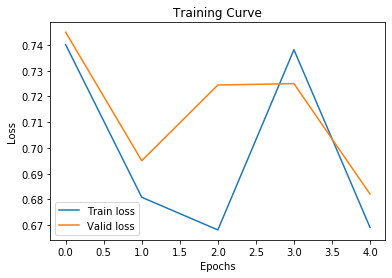

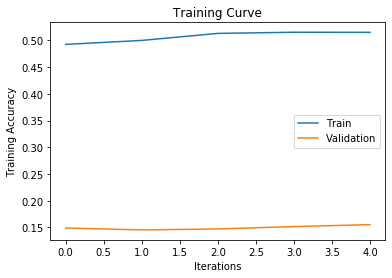

Most Recent Training Accuracy = 0.5150666886217685
Most Recent Validation Accuracy = 0.15515695067264573
Max Training Accuracy = 0.5152313518853944
Max Validation Accuracy = 0.15515695067264573
Most Recent Training Loss = tensor(0.6691, grad_fn=<NllLossBackward>)
Most Recent Validation Loss = tensor(0.6821, grad_fn=<NllLossBackward>)
Min Training Loss = tensor(0.6682, grad_fn=<NllLossBackward>)
Min Validation Loss = tensor(0.6821, grad_fn=<NllLossBackward>)


In [185]:
'''
using default values
'''
batch = 32
lr = 10**-5
epochs = 5
neurons = 100
plot = True
max_or_avg = 0
train_iter, valid_iter, test_iter, text_dict, text_list, train, valid, test = get_data(batch)
input_amount = len(text_list)
spam_bot_0 = Spammer(input_amount, neurons, max_or_avg)
train_bot(spam_bot_0, train_iter, valid_iter, epochs, lr, plot)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [193]:
'''
For the first test, I increased the batch size form 32 to 64 to increase accuracy.
I increased the number of neurons so that each feature can have more of an impact 
on the weights of the neuron. I also increased the number of epochs as the optimal
solution has not been reached. 
'''
batch = 64
lr = 0.00001
epochs = 20
neurons = 225
plot = False
train_iter, valid_iter, test_iter, text_dict, text_list, train, valid, test = get_data(batch)
input_amount = len(text_list)
spam_bot_1 = Spammer(input_amount, neurons, max_or_avg)
train_bot(spam_bot_1, train_iter, valid_iter, epochs, lr, plot)

3343 1115 1114
6073
defaultdict(<function _default_unk_index at 0x7f95a2a150d0>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, 'T': 27, '8': 28, 'k': 29, 'E': 30, 'v': 31, '5': 32, 'C': 33, 'S': 34, 'O': 35, 'I': 36, 'N': 37, '7': 38, '4': 39, 'A': 40, 'x': 41, '6': 42, '3': 43, '!': 44, 'R': 45, 'P': 46, ',': 47, '9': 48, 'W': 49, 'U': 50, 'M': 51, 'L': 52, 'H': 53, 'B': 54, 'D': 55, 'G': 56, 'Y': 57, 'F': 58, "'": 59, '/': 60, '?': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, 'K': 69, 'j': 70, '*': 71, ')': 72, 'J': 73, '+': 74, ';': 75, '(': 76, 'Q': 77, 'q': 78, '"': 79, '>': 80, '#': 81, '@': 82, '=': 83, 'Z': 84, 'ü': 85, 'Ü': 86, '$': 87, '<': 88, '\x92': 89, '|': 90, '‘': 91, '_': 92, '\x93': 93, '“': 94, '…': 95, '%': 96, '[': 97, ']': 98, '–': 99, '\x94': 100, '

ValueError: ignored

In [189]:
'''
For the second test, I increased the batch size form 64 to 128, 
as i felt that the first test accuracies can be improved. I increased 
the number of neurons even more since in the first test in order to further 
improve accuracy. I decrease the number of epochs in order to reduce overfitting
of the training set. I reduce the learning rate a small amount to see if I 
can obtain a more accurate value
'''
batch = 128
lr = 0.000009
epochs = 15
neurons = 300
plot = False
train_iter, valid_iter, test_iter, text_dict, text_list, train, valid, test = get_data(batch)
input_amount = len(text_list)
spam_bot_2 = Spammer(input_amount, neurons, max_or_avg)
train_bot(spam_bot_2, train_iter, valid_iter, epochs, lr, plot)

3343 1115 1114
6073
defaultdict(<function _default_unk_index at 0x7f95a2a150d0>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, 'T': 27, '8': 28, 'k': 29, 'E': 30, 'v': 31, '5': 32, 'C': 33, 'S': 34, 'O': 35, 'I': 36, 'N': 37, '7': 38, '4': 39, 'A': 40, 'x': 41, '6': 42, '3': 43, '!': 44, 'R': 45, 'P': 46, ',': 47, '9': 48, 'W': 49, 'U': 50, 'M': 51, 'L': 52, 'H': 53, 'B': 54, 'D': 55, 'G': 56, 'Y': 57, 'F': 58, "'": 59, '/': 60, '?': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, 'K': 69, 'j': 70, '*': 71, ')': 72, 'J': 73, '+': 74, ';': 75, '(': 76, 'Q': 77, 'q': 78, '"': 79, '>': 80, '#': 81, '@': 82, '=': 83, 'Z': 84, 'ü': 85, 'Ü': 86, '$': 87, '<': 88, '\x92': 89, '|': 90, '‘': 91, '_': 92, '\x93': 93, '“': 94, '…': 95, '%': 96, '[': 97, ']': 98, '–': 99, '\x94': 100, '

In [190]:
'''
For the third test, I increased the number of epochs as the prior test did not converge
fast enough. I also reduced the batch size to make the computation must faster.
Reducing the computation would improve the model. I increased the number 
of epochs as the test before did not manage to reach an optimal solution (underfitting). 
I kept the batch size and lr the same to see if the other parameters would 
improve the accuracy.
'''
batch = 64
lr = 0.000009
epochs = 18
neurons = 250
plot = False
train_iter, valid_iter, test_iter, text_dict, text_list, train, valid, test = get_data(batch)
input_amount = len(text_list)
spam_bot_3 = Spammer(input_amount, neurons, max_or_avg)
train_bot(spam_bot_3, train_iter, valid_iter, epochs, lr, plot)

3343 1115 1114
6073
defaultdict(<function _default_unk_index at 0x7f95a2a150d0>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, 'T': 27, '8': 28, 'k': 29, 'E': 30, 'v': 31, '5': 32, 'C': 33, 'S': 34, 'O': 35, 'I': 36, 'N': 37, '7': 38, '4': 39, 'A': 40, 'x': 41, '6': 42, '3': 43, '!': 44, 'R': 45, 'P': 46, ',': 47, '9': 48, 'W': 49, 'U': 50, 'M': 51, 'L': 52, 'H': 53, 'B': 54, 'D': 55, 'G': 56, 'Y': 57, 'F': 58, "'": 59, '/': 60, '?': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, 'K': 69, 'j': 70, '*': 71, ')': 72, 'J': 73, '+': 74, ';': 75, '(': 76, 'Q': 77, 'q': 78, '"': 79, '>': 80, '#': 81, '@': 82, '=': 83, 'Z': 84, 'ü': 85, 'Ü': 86, '$': 87, '<': 88, '\x92': 89, '|': 90, '‘': 91, '_': 92, '\x93': 93, '“': 94, '…': 95, '%': 96, '[': 97, ']': 98, '–': 99, '\x94': 100, '

In [196]:
'''
For the last test, I re-increased the epochs as it was not converging fast enough
I also decreased the number of neurons to speed up convergence
'''
batch = 64
lr = 0.00001
epochs = 15
neurons = 250
plot = False
train_iter, valid_iter, test_iter, text_dict, text_list, train, valid, test = get_data(batch)
input_amount = len(text_list)
spam_bot_4 = Spammer(input_amount, neurons, max_or_avg)
train_bot(spam_bot_4, train_iter, valid_iter, epochs, lr, plot)

3343 1115 1114
6073
defaultdict(<function _default_unk_index at 0x7f95a2a150d0>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '2': 25, 'b': 26, 'T': 27, '8': 28, 'k': 29, 'E': 30, 'v': 31, '5': 32, 'C': 33, 'S': 34, 'O': 35, 'I': 36, 'N': 37, '7': 38, '4': 39, 'A': 40, 'x': 41, '6': 42, '3': 43, '!': 44, 'R': 45, 'P': 46, ',': 47, '9': 48, 'W': 49, 'U': 50, 'M': 51, 'L': 52, 'H': 53, 'B': 54, 'D': 55, 'G': 56, 'Y': 57, 'F': 58, "'": 59, '/': 60, '?': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, 'K': 69, 'j': 70, '*': 71, ')': 72, 'J': 73, '+': 74, ';': 75, '(': 76, 'Q': 77, 'q': 78, '"': 79, '>': 80, '#': 81, '@': 82, '=': 83, 'Z': 84, 'ü': 85, 'Ü': 86, '$': 87, '<': 88, '\x92': 89, '|': 90, '‘': 91, '_': 92, '\x93': 93, '“': 94, '…': 95, '%': 96, '[': 97, ']': 98, '–': 99, '\x94': 100, '

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [198]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)
'''
false positive = where looks like spam on not spam
false negative = looks like not spam on spam
'''
valid_spam = torchtext.data.BucketIterator(valid_spam,
                                           batch_size=batch,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
valid_nospam = torchtext.data.BucketIterator(valid_nospam,
                                           batch_size=batch,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
print('error of no spam (false positive)= {}'.format(1 - get_accuracy(spam_bot_4, valid_nospam)))
print('error of spam (false negative)= {}'.format(1 - get_accuracy(spam_bot_4, valid_spam)))

error of no spam (false positive)= 0.07875647668393781
error of spam (false negative)= 0.19333333333333336


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [0]:
'''
False positive
This is bad since it takes real texts and removes them from your messages as they
appear as spam. This could cause a lot of problems as important texts could be 
discarded from the set. Also, for service locations (restaurants, clinics) may
have a text feature for a wait queue (text when close to front of the queue) and those
texts could potentially be seen as spam. Minimizing false positives should be
a priority as it is more catastropic. 

False negatives
Although this may be annoying for the user, it does not have the repercussions
of false negatives. The user may receiver a small amount of spam messages every so
often where the AI was unable to detect. 
'''

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [199]:
print(get_accuracy(spam_bot_4, test_iter))

0.921903052064632


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [200]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)
test_spam = torchtext.data.BucketIterator(test_spam,
                                           batch_size=batch,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
test_nospam = torchtext.data.BucketIterator(test_nospam,
                                           batch_size=batch,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
'''
false positive = where looks like spam on not spam
false negative = looks like not spam on spam
'''
print('error of no spam (false positive)= {}'.format(1 - get_accuracy(spam_bot_4, test_nospam)))
print('error of spam (false negative)= {}'.format(1 - get_accuracy(spam_bot_4, test_spam)))

error of no spam (false positive)= 0.06481481481481477
error of spam (false negative)= 0.147887323943662


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [218]:
msg = "machine learning is sooo cool!"
char_list = list(msg)
for i in range(len(char_list)):
  char_list[i] = text_field.vocab.stoi[char_list[i]]
char_list = torch.LongTensor(char_list)
char_list = char_list.unsqueeze(1)
char_list = char_list.numpy()
char_list = np.transpose(char_list)
char_list = torch.from_numpy(char_list)
out = spam_bot_4(char_list)
print(torch.argmax(out, 1))
'''
Since the max index is 0, the AI shows that the message is not spam
'''

tensor([0])


'\nSince the max index is 0, the AI shows that the message is not spam\n'

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [0]:
'''
Detecting spam does not seem like that difficult of a challenge. Spam messages usually
contain specific keywords and patterns that are recognizable by humans. 

Since spam messages use specific keywords and use perfect english, you can create
an algorithm that goes through some spam messages, keeps track using a counter in a list
of the most used words i.e. 'won' and 'congratulations', etc. 

You can also create another algorithm that checks whether the text uses good 
english; checking if the first letter is a capital at the begining the sentence, 
using punctuation (humans dont use much punctuation during texts), and no 
mispelled or fake words. 

When you receive a text, you can use algorithm 2 to check whether the english 
is non humanly perfect. If it is perfect, you can compare the words used in the text
with spam texts using algorithm 1. If a majority is used, you can say it is most 
likely spam. 

This works as a good baseline as humans dont tend to use perfect spelling and 
capitalization. They use abreviations such as lol and lmao which spam texts usually
dont use. Also, human texts dont use proper punctuation either such as ', ". etc. 
Therefore this would work as a decent baseline model as it would not be too difficult
to build.
'''